<h1>Sunspot Time-Series Sunspot Exercise</h1>

This dataset describes a monthly count of the number of observed sunspots for just over 230 years (1749-1983). The units are a count and there are 2,820 observations. The source of the dataset is credited to Andrews & Herzberg (1985). The dataset was retrieved courtesy of Jason Brownlee from <i>machinelearningmastery.com</i>. The specific link is provided below:

<a>https://machinelearningmastery.com/time-series-datasets-for-machine-learning/</a>

In this project, we perform time-series analysis using signal processing techniques for stochastic sequences such as autocorrelation to determine whether or not there is some underlying periodicity to the raw data as well as general techniques such as Fourier Transformations and LTI-filtering when necessary. 

In [435]:
# Importing packages:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib import rc,rcParams

# activate latex text rendering
rc('text', usetex=False)
rc('axes', linewidth=1)
rc('font', weight='normal')
rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

# Load data into workspace:
raw = pd.read_csv("monthly-sunspots.txt")

Check out the first few rows of the dataset:

In [436]:
raw.head(15)

,Month,Sunspots
0,1749-01,58.0
1,1749-02,62.6
2,1749-03,70.0
3,1749-04,55.7
4,1749-05,85.0
5,1749-06,83.5
6,1749-07,94.8
7,1749-08,66.3
8,1749-09,75.9
9,1749-10,75.5


Check if any of the sunspots are null values and need to be imputed. In this case, there are no null values which need to be filled!

In [437]:
sum(raw['Sunspots'].isna())

0

It might prove useful to separate the year and the month into their separate columns. We'll keep the original 'Month' column but rename it to 'year_month' to avoid confusion.

In [438]:
# Renaming columns to appropriate names and using snakecase for ease. 
raw.columns = ['year_month', 'sunspots']

# Separate the 'year_month' entry into two columns using the '-' separator
raw[['year', 'month']] = raw['year_month'].str.split('-', expand=True).astype(int)
raw.head()

,year_month,sunspots,year,month
0,1749-01,58.0,1749,1
1,1749-02,62.6,1749,2
2,1749-03,70.0,1749,3
3,1749-04,55.7,1749,4
4,1749-05,85.0,1749,5


We'll add another column that contains the month number since 1749 starting from 0 (which represents the first sunspot indicated on 1749-01). This shown in the modified dataframe below:

In [439]:
month_num = pd.Series(np.arange(0,len(raw),1))
raw['month_num'] = month_num
raw.head()

,year_month,sunspots,year,month,month_num
0,1749-01,58.0,1749,1,0
1,1749-02,62.6,1749,2,1
2,1749-03,70.0,1749,3,2
3,1749-04,55.7,1749,4,3
4,1749-05,85.0,1749,5,4


<h2>Plotting The Sunspot Time-Series</h2>

<IPython.core.display.Javascript object>


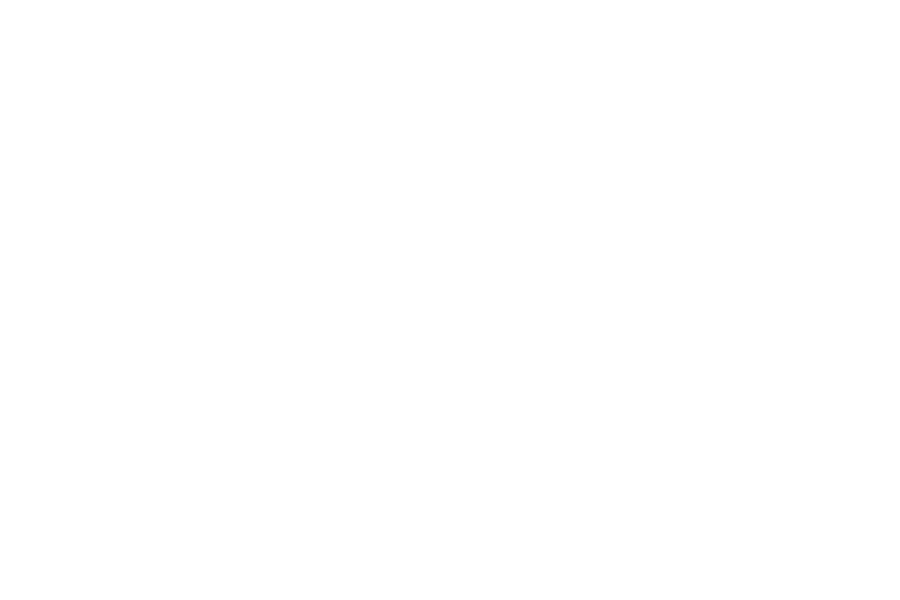

In [440]:
# Let x be the sunspots column of the dataframe:
x = np.array(raw['sunspots'])

# Let n be the month number (which can be thought of as the sample number)
n = np.array(raw['month_num'])

# Plot the time-series:
fig = plt.subplots(figsize=(9,6))
plt.plot(n,x)
plt.xlim([0, len(raw)])
plt.xlabel("Months Since January 1749")
plt.ylabel("Sunspots Detected")
plt.title("Sunspot Detections From 1749 to 1983")
plt.show()

<h2>Computing The FFT and PSD For The Sunspot Time-Series</h2>

<IPython.core.display.Javascript object>


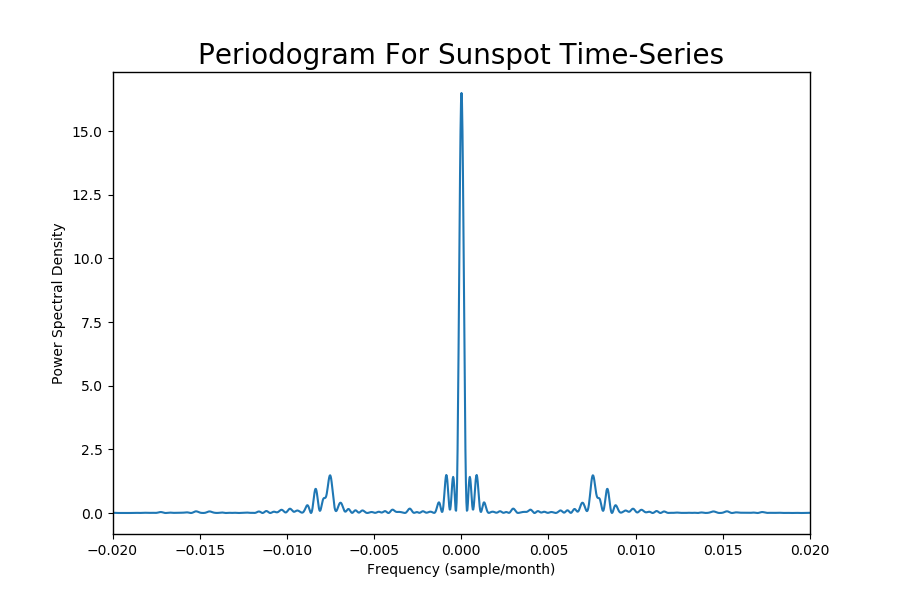

In [441]:
from scipy.fftpack import fft, fftshift

# Sample support for data is n = 0...N-1 where N is the length of the time-series. We may need to zero pad to increase
# the spectral resolution as well. Perhaps add 2^14 more zeros. Add zero at the end

# Create the zero-padding.
zero_padding = np.zeros(2**15)
x_zp = np.concatenate([x, zero_padding])

L = len(x)        # Length of the original sequence
N = len(x_zp)     # Length of the zero-padded sequence.

# Compute the normalised FFT of the discrete sequence:
x_hat = fftshift(fft(x)) / (L)
x_zp_hat = fftshift(fft(x_zp)) / (N)

# Compute the PSD of raw_hat
x_psd = abs(raw_hat)**2
x_zp_psd = abs(raw_zp_hat)**2

# Since the sampling period is essentially "1 month/sample", we can say that T = 1 which is the same as the sampling frequency:
T = 1;
fs = 1/T;

# This means the Nyquist frequency must be at least HALF the sampling rate. f_nyq is ALSO the maximum possible frequency
# in the frequency domain. We may think of this as sampling every HALF of a month
f_nyq = fs/2;

# Frequency axis for the non-zero padded sequence:
freqx = np.linspace(-f_nyq, f_nyq, L);

# We can then generate a frequency-axis for the PSD with equal sample support to the ZERO-PADDED sequence
freqx_zp = np.linspace(-f_nyq, f_nyq, N);

# Now we can plot the PSD and see how the powers are distributed across the frequencies and the impact of the noise on the
# PSD:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(freqx_zp, x_zp_psd)
ax.set_xlim([-0.02, 0.02])
ax.set_ylabel("Power Spectral Density")
ax.set_xlabel("Frequency (sample/month)")
ax.set_title("Periodogram For Sunspot Time-Series", fontsize=20)
plt.show()

What we see is a large DC component as a result of the time-series oscillating about a non-zero sunspot count. We can remove this DC offset by removing the mean or by using some high-pass filter with a steep cutoff 0.005 sample/month. Other than the DC offset, we can see two noticeable peaks at $\pm 0.007 Hz$ which are peaks likely associated with the sinusoidal behavious of the time-series.

Those peaks most likely signify the frequency with which the <b>maximum</b> number of sunspots occur. If we express the horizontal axis in terms of periods (months/sample) as opposed to frequency, we can make sense of WHEN these peaks occur. We perform this conversion and a re-plotting in the code cell below. 

In this case, since the positive peak occurs at $f = 0.007$ $sample/month$, this corresponds to a period of $142.85$ $months/sample$. This means that only after every 142.85 months will a maximum number of sunspot counts occur! Converting this to years this would compute to $11.90$ $years/sample$ which is consistent with the current scientific literature that the peak sunspot activity occurs every 11 years!

<h1>Short-Time Fourier Transform (STFT) On The Data</h1>

The Fourier Transform, alone, operated on the entire signal is <b>not</b> a reliable way of determining the peak frequency in the data. This peak may change as a result of the non-stationary nature of the signal (which is essentially our time-series). This gives rise to the use of the STFT as a way to see the variation in the peak frequency in terms of contiguous block of the data. 

The STFT is computed using a time-limited window, $w[n]$ that is delayed by some number of samples $\tau \in \mathbb{Z}$ and multiplying on the discrete sequence, $x[n]$ for $n \geq 0$. The product is then Fourier transformed to obtain the frequency spectrum of that small chunk of data. Mathematically, the STFT can be expressed as:

\begin{equation}
    \mathbf{STFT}\{x[n]\}(\tau, \omega) = \sum_{n = 0}^{\infty} x[n]w[n-\tau]e^{-jn\omega} 
\end{equation}

The STFT of these blocks can then be joined together to form a 2D spectrogram of the data where the colour is indicative of the amplitude of the frequencies over time. We need to be aware that the STFT, however, has a fixed frequency resolution for all time. The Wavelet Transform offers more flexibility but for now we'll just use the STFT for practice sake.

<IPython.core.display.Javascript object>


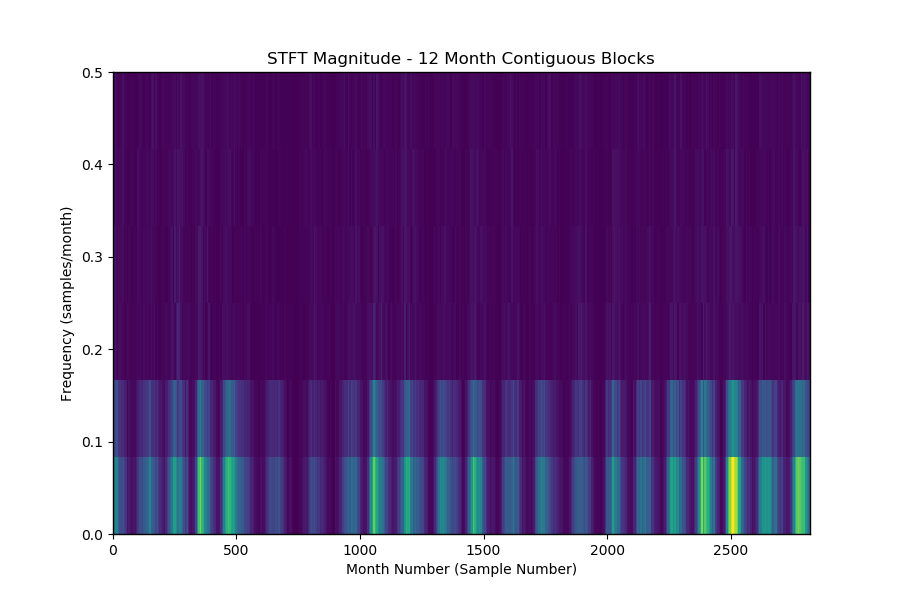

In [442]:
from scipy.signal import stft

# Compute the STFT for the signal. Let the number of samples per segment (nperseg) be 12 (every year)
f,t,Zxx = stft(x, fs, nperseg=12)

fig = plt.figure(figsize=(9,6))
plt.pcolormesh(t,f,np.abs(Zxx), vmin=0)
plt.xlabel("Month Number (Sample Number)")
plt.ylabel("Frequency (samples/month)")
plt.title("STFT Magnitude - 12 Month Contiguous Blocks")
plt.show()

<h2>Autocorrelation As Another Way Of Finding Maximum Sunspot Activity</h2>

The autocorrelation of a sequence, $x[n]$ computes the similarity between a signal and a delayed version of itself by some lag $m$. Mathematically, this can be computed as:

\begin{equation}
    r_{xx}[m] = \frac{1}{2N+1} \sum_{n = -N}^{N}x[n]x[n-m]
\end{equation}

The delayed signal acts almost as a moving window and is multiplied by the original sequence. The more 'similar' the two sequences are, the greater the value of their product. Any signal exhibiting some degree of periodicity will reach some non-zero lag $m$ corresponding to another local maximum value for $r_{xx}[m]$. We compute the autocorrelation sequence for our time-series below and see if it can justify the 11-year cycle for maximum sunspot activity.

<IPython.core.display.Javascript object>


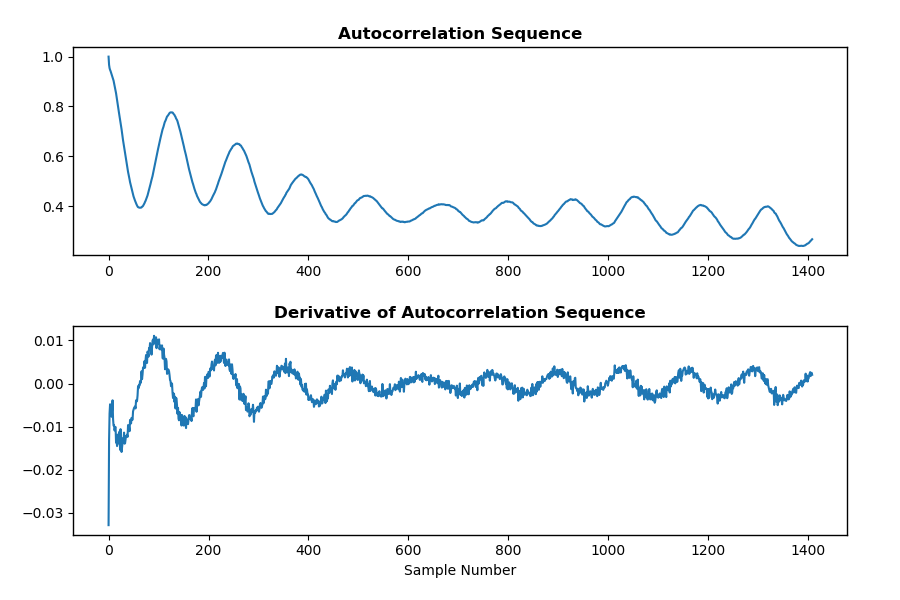

In [443]:
rxx = np.correlate(x,x,mode='same')

# Normalise and take only the second half of the sequence.
rxx = rxx / max(rxx);
rxx = rxx[len(rxx)//2:];

# Compute the derivative:
rxx_diff = np.diff(rxx);

fig, ax = plt.subplots(figsize=(9,6), nrows=2, ncols=1)
fig.tight_layout(pad=3.0);
ax[0].plot(rxx);
ax[0].set_title("Autocorrelation Sequence", fontweight='bold');
ax[1].plot(rxx_diff);
ax[1].set_title("Derivative of Autocorrelation Sequence", fontweight='bold');
ax[1].set_xlabel("Sample Number");

We can see from the interactive plot above that the second (maximum) peak occurs at a large of approximately at a lag of 126. This means after 126 months or 10.5 years, we will get another maximum sunspot activity occurring which is an approximation consistent with the observation of maximum sunspot activity occurring every 11 years!

The PSD method is relatively inaccurate (compared to this method of using autocorrelation) because of the presence of noise and issues with spectral resolution despite adding $2^{15}$ more zeros. While this increases our ability to resolve between peaks in the spectra does not guarantee that these are necessarily the true peaks; they are <b>interpolated</b> as a result of the zero-padding.